# Fichier Global Deep Learning - M2 SISE - 2023 
Houde Titouan et Ricard Florian

## Import des données

In [1]:
import sys
print(sys.version)

3.8.8 (default, Apr 13 2021, 12:59:45) 
[Clang 10.0.0 ]


In [23]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F

In [4]:
working_dir = r'/Users/RICARD/Documents/Etudiant/M2_SISE/ML_DeepLearning/Projet_CNN_ML/Post-hurricane'

In [5]:
train_damage_dir = working_dir + '/train_another/damage'
validation_damage_dir = working_dir + '/validation_another/damage'
test_damage_dir = working_dir + '/test/damage'

train_nodamage_dir = working_dir + '/train_another/no_damage'
validation_nodamage_dir = working_dir + '/validation_another/no_damage'
test_nodamage_dir = working_dir + '/test/no_damage'

In [14]:
os.listdir(working_dir)

['.DS_Store',
 'test',
 'validation_another',
 'tomnod_everything_relu_Adam.h5',
 'train_another',
 'test_another']

In [6]:
print('total training damage images: ',len(os.listdir(train_damage_dir)))
print('total validation damage images: ',len(os.listdir(validation_damage_dir)))
print('total test damage images: ',len(os.listdir(test_damage_dir)))

print('total training no damage images: ',len(os.listdir(train_nodamage_dir)))
print('total validation no damage images: ',len(os.listdir(validation_nodamage_dir)))
print('total test no damage images: ',len(os.listdir(test_nodamage_dir)))

total training damage images:  5000
total validation damage images:  1000
total test damage images:  1000
total training no damage images:  5000
total validation no damage images:  1000
total test no damage images:  1000


In [18]:
#train and test data directory
train_dir = "/Users/RICARD/Documents/Etudiant/M2_SISE/ML_DeepLearning/Projet_CNN_ML/Post-hurricane/train_another"
valid_dir = "/Users/RICARD/Documents/Etudiant/M2_SISE/ML_DeepLearning/Projet_CNN_ML/Post-hurricane/validation_another"



train = ImageFolder(train_dir,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

valid = ImageFolder(valid_dir,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

print("Model's classes : \n",train.classes)


Model's classes : 
 ['damage', 'no_damage']


In [11]:
# check image size after transform
img, label = train[0]
print(img.shape,label)

torch.Size([3, 150, 150]) 0


Label : damage


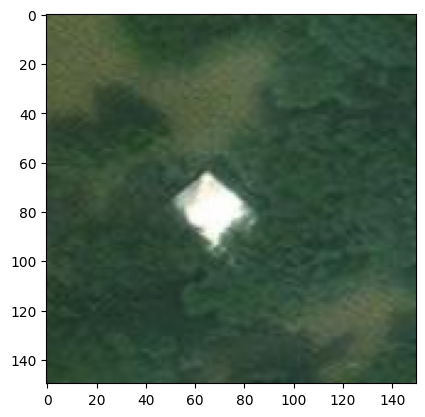

In [16]:
# Fontion d'afficha des données
def display_img(img,label):
    print(f"Label : {train.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*train[0])

In [20]:
# Préparation des données pour l'entrainement des modèles
train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=32, shuffle=True)

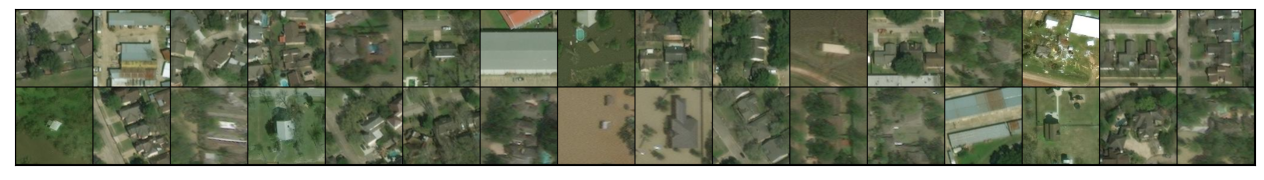

In [22]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_loader)

## CNN et Apprentissage sur les données

In [35]:
# Création du CNN vu dans l'article
class CNN_Classification(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, (3,3)),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(32, 64, (3,3)),
            nn.ReLU(),
            nn.MaxPool2d(2,2),#

            nn.Conv2d(64, 128, (3,3)),
            nn.ReLU(),#
            nn.MaxPool2d(2,2),
            nn.Conv2d(128, 128, (3,3)),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 2),
            nn.Sigmoid()
        )
    
    def forward(self, xb):
        return self.network(xb)

In [39]:
modelA = CNN_Classification()
modelA

CNN_Classification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=6272, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=2, bias=True)
    (16): Sigmoid()
  )
)

In [40]:
from torch import optim


# Paramètrage 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # GPU pour les parties sur Google Colab
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(modelA.parameters(), lr=0.001, amsgrad=True)

In [41]:
# Architexture du modèle CNN
from torchinfo import summary
summary(modelA)

Layer (type:depth-idx)                   Param #
CNN_Classification                       --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       896
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       18,496
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Conv2d: 2-7                       73,856
│    └─ReLU: 2-8                         --
│    └─MaxPool2d: 2-9                    --
│    └─Conv2d: 2-10                      147,584
│    └─ReLU: 2-11                        --
│    └─MaxPool2d: 2-12                   --
│    └─Flatten: 2-13                     --
│    └─Linear: 2-14                      3,211,776
│    └─ReLU: 2-15                        --
│    └─Linear: 2-16                      1,026
│    └─Sigmoid: 2-17                     --
Total params: 3,453,634
Trainable params: 3,453,634
Non-trainable params: 0

In [58]:
# Entrainement
for epoch in range(10):  # Boucle sur les époques
    running_loss = 0
    step_train = 0
    for i, data in enumerate(train_loader, 0): # Parcours les batchs du train_loader
        inputs, labels = data

        optimizer.zero_grad() # En enlève les résidus de gradient avec une étape
        outputs = modelA(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        step_train +=1
        if step_train%20 == 0:
            print("Training Step ", step_train)
            
        if step_train == 100 :
            break
    # Boucle de validation
    with torch.no_grad():
        correct = 0
        total = 0
        step_val = 0
        for data in valid_loader:
            images, labels = data
            outputs = modelA(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if step_val==30:
                break

        print('Epoch %d : Validation accuracy of the network on the validation images: %d %%' % (epoch + 1,100 * correct / total))

print('Finished Training')


Training Step  20
Training Step  40
Training Step  60
Training Step  80
Training Step  100
Epoch 1 : Validation accuracy of the network on the validation images: 87 %
Training Step  20
Training Step  40
Training Step  60
Training Step  80
Training Step  100
Epoch 2 : Validation accuracy of the network on the validation images: 86 %
Training Step  20
Training Step  40
Training Step  60
Training Step  80
Training Step  100
Epoch 3 : Validation accuracy of the network on the validation images: 88 %
Training Step  20
Training Step  40
Training Step  60
Training Step  80
Training Step  100
Epoch 4 : Validation accuracy of the network on the validation images: 88 %
Training Step  20
Training Step  40
Training Step  60
Training Step  80
Training Step  100
Epoch 5 : Validation accuracy of the network on the validation images: 85 %
Training Step  20
Training Step  40
Training Step  60
Training Step  80
Training Step  100
Epoch 6 : Validation accuracy of the network on the validation images: 87 

In [166]:
# Création d'un second CNN avec modification sur les couches et les paramètres
class CNN_Classification_Base(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=6),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(64, 128, kernel_size=6),
            nn.ReLU(),
            nn.MaxPool2d(2,2),#

            nn.Conv2d(128, 256, kernel_size=6),
            nn.ReLU(),#
            nn.MaxPool2d(2,2),

            nn.Conv2d(256, 256, kernel_size=6),
            nn.ReLU(),#
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Linear(512, 2),
            nn.ReLU()
        )
    
    def forward(self, xb):
        return self.network(xb)

In [167]:
modelB = CNN_Classification_Base()
modelB

CNN_Classification_Base(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(6, 6), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(6, 6), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(6, 6), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 256, kernel_size=(6, 6), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=4096, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=2, bias=True)
    (16): ReLU()
  )
)

In [168]:
summary(modelB)

Layer (type:depth-idx)                   Param #
CNN_Classification_Base                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       6,976
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       295,040
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Conv2d: 2-7                       1,179,904
│    └─ReLU: 2-8                         --
│    └─MaxPool2d: 2-9                    --
│    └─Conv2d: 2-10                      2,359,552
│    └─ReLU: 2-11                        --
│    └─MaxPool2d: 2-12                   --
│    └─Flatten: 2-13                     --
│    └─Linear: 2-14                      2,097,664
│    └─ReLU: 2-15                        --
│    └─Linear: 2-16                      1,026
│    └─ReLU: 2-17                        --
Total params: 5,940,162
Trainable params: 5,940,162
Non-trainable params: 0

In [169]:
# Définir la fonction de coût
criterion = nn.CrossEntropyLoss()

# Définir l'optimiseur
optimizerB = optim.Adam(modelB.parameters(), lr=0.003)

In [170]:
for epoch in range(10):  # Boucle sur les époques
    running_loss = 0
    step_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizerB.zero_grad()
        outputs = modelB(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizerB.step()

        running_loss += loss.item()

        step_train +=1
        if step_train%20 == 0:
            print("Training Step ", step_train)
            
        if step_train == 100 :
            break
    # Boucle de validation
    with torch.no_grad():
        correct = 0
        total = 0
        step_val = 0
        for data in valid_loader:
            images, labels = data
            outputs = modelB(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if step_val==30:
                break

        print('Epoch %d : Validation accuracy of the network on the validation images: %d %%' % (epoch + 1,100 * correct / total))

print('Finished Training')


Training Step  20
Training Step  40
Training Step  60
Training Step  80
Training Step  100
Epoch 1 : Validation accuracy of the network on the validation images: 50 %
Training Step  20
Training Step  40


KeyboardInterrupt: 

## Features extraction - Transfer Learning

In [51]:
# Dépendances 
import torch
from torch.autograd import Variable
from PIL import Image
import os
import pandas as pd
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.metrics import f1_score, confusion_matrix, classification_report, make_scorer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Fonction de récupération des features dans une image
def get_vector(image_name):

    # Charger une image avec la librarie Pillow
    img = Image.open(image_name)
    # Créer une variable Pytorch afin de 
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
    # Créer un vecteur de 0 qui contiendra les features 
    my_embedding = torch.zeros(512)
    # Définir une fonction qui copy les résultats dans les couches
    def copy_data(m, i, o):
        my_embedding.copy_(o.data.reshape(o.data.size(1)))
    h = layer.register_forward_hook(copy_data)
    # Lancer le modèle sur l'image 
    model(t_img)
    h.remove()
    # Renvoyer les features
    return my_embedding.numpy()

# Fonction qui boucle sur toutes les images d'un jeu de données
def features_train(directory):

    # On instancie les listes qui stockeront les informations
    features = []
    totaldir = []
    y = []
    
    # Liste avec tous les chemins des images
    damage_dir = str(directory + "/damage/")
    damage = os.listdir(damage_dir)
    for i in damage :
        totaldir.append(str(damage_dir + i))
        y.append("damage")
    
    no_damage_dir = str(directory + "/no_damage/")
    no_damage = os.listdir(no_damage_dir)
    for i in no_damage :
        totaldir.append(str(no_damage_dir + i))
        y.append("no_damage")

    # Récupération des features dans les images
    for dir in totaldir : 
        features.append(get_vector(dir))

    features = pd.DataFrame(features)

    return features, y

# Fonction d'évaluation
def evaluation(model, X_train, y_train, X_test, y_test, target_names):
  model.fit(X_train, y_train)
  ypred = model.predict(X_test)

  print(pd.DataFrame(confusion_matrix(y_test,ypred), 
                  columns=['pred_0','pred_1'],
                  index=['obs_0','obs_1']))
                  

  print(classification_report(y_test, ypred, target_names = target_names))

# Fonction de Gridsearch
def grid_search(model, parameters, scorer, cv, X_train, y_train):

    best_model = GridSearchCV(model,param_grid = parameters, scoring = scorer, verbose = 2, cv = cv)
    best_model.fit(X_train, y_train)

    return best_model.best_estimator_, best_model.scorer_, best_model.best_score_

In [3]:
# Chemin des différents datasets
train = "/Users/titouanhoude/Deep Learning/Post-hurricane/train_another"
validation = "/Users/titouanhoude/Deep Learning/Post-hurricane/validation_another"
balanced_test = "/Users/titouanhoude/Deep Learning/Post-hurricane/test"
unbalanced_test = "/Users/titouanhoude/Deep Learning/Post-hurricane/test_another"

# Charger un modèle pré-entraîné
model = models.resnet18(pretrained=True)

# Utiliser ce modèle pour obtenir la couche qui nous intérésse
layer = model._modules.get('avgpool')

# Evaluer ce modèle
model.eval()

# Transformer les images dans le bon format, normalisation et conversion en Tenseur
scaler = transforms.Resize((150, 150))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

X_train, y_train = features_train(train)
X_test, y_test = features_train(validation)

In [50]:
# Knn
knn = KNeighborsClassifier(n_neighbors=5)
target_names = ["damage", "no_damage"]

evaluation(knn, X_train, y_train, X_test, y_test, target_names)

       pred_0  pred_1
obs_0     942      58
obs_1     124     876
              precision    recall  f1-score   support

      damage       0.88      0.94      0.91      1000
   no_damage       0.94      0.88      0.91      1000

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



In [10]:
# Random Forest de base
clf = RandomForestClassifier(random_state=0)
target_names = ["damage", "no_damage"]

evaluation(clf, X_train, y_train, X_test, y_test, target_names)

       pred_0  pred_1
obs_0     873     127
obs_1      85     915
              precision    recall  f1-score   support

      damage       0.91      0.87      0.89      1000
   no_damage       0.88      0.92      0.90      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



In [37]:
# Paramètres de la Grid Search
parameters = {'n_estimators' : np.arange(start = 10, stop = 210, step = 25), 
    'max_depth' : np.arange(start = 10, stop = 20, step = 2)}
model = RandomForestClassifier()
scorer = make_scorer(f1_score , average='macro')
cv = 3

# Grid Search du Random Forest
best_estimator, best_scorer, best_score_ = grid_search(model, parameters, scorer, cv, X_train, y_train)

print("Voici les paramètres du meilleure modèle : " + str(best_estimator))
print("Voici le "  + str(best_scorer) + " du meilleure modèle : " + str(best_score_))

In [40]:
# Evaluation du modèle Random Forest avec les meilleurs paramètres
clf = RandomForestClassifier(max_depth=16, n_estimators=110)
target_names = ["damage", "no_damage"]

evaluation(clf, X_train, y_train, X_test, y_test, target_names)

       pred_0  pred_1
obs_0     868     132
obs_1      78     922
              precision    recall  f1-score   support

      damage       0.92      0.87      0.89      1000
   no_damage       0.87      0.92      0.90      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.89      2000
weighted avg       0.90      0.90      0.89      2000



In [52]:
# Evaluation du modèle XGB avec les meilleurs paramètres
xgb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
target_names = ["damage", "no_damage"]

evaluation(clf, X_train, y_train, X_test, y_test, target_names)

       pred_0  pred_1
obs_0     866     134
obs_1      75     925
              precision    recall  f1-score   support

      damage       0.92      0.87      0.89      1000
   no_damage       0.87      0.93      0.90      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



## Approche B - Transfer Learning

In [2]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd 
import numpy as np
import os
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from PIL import Image
import numpy as np
import os
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd
from torchinfo import summary



In [4]:
# Connexion à ggdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
working_dir = '/content/drive/MyDrive/M2_SISE/DL_MLProjet/Post-hurricane'

In [6]:
train_damage_dir = working_dir + '/train_another/damage'
validation_damage_dir = working_dir + '/validation_another/damage'
test_damage_dir = working_dir + '/test/damage'

train_nodamage_dir = working_dir + '/train_another/no_damage'
validation_nodamage_dir = working_dir + '/validation_another/no_damage'
test_nodamage_dir = working_dir + '/test/no_damage'

train_dir = working_dir + "/train_another"
valid_dir = working_dir + "/validation_another"

print('total training damage images: ',len(os.listdir(train_damage_dir)))
print('total validation damage images: ',len(os.listdir(validation_damage_dir)))
print('total test damage images: ',len(os.listdir(test_damage_dir)))

print('total training no damage images: ',len(os.listdir(train_nodamage_dir)))
print('total validation no damage images: ',len(os.listdir(validation_nodamage_dir)))
print('total test no damage images: ',len(os.listdir(test_nodamage_dir)))

total training damage images:  5000
total validation damage images:  1000
total test damage images:  1000
total training no damage images:  5000
total validation no damage images:  1000
total test no damage images:  1000


In [7]:
train = ImageFolder(train_dir,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

valid = ImageFolder(valid_dir,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

print("Model's classes : \n",train.classes)

Model's classes : 
 ['damage', 'no_damage']


### Modèle Densenet121

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet121(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.003)

In [14]:
train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, num_workers=2 , pin_memory = True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=32, shuffle=True, num_workers=2 , pin_memory = True)


In [15]:
# Changement de la dernière couche pour s'adapter à notre classification
        
n_classes = 2
model.fc = nn.Linear(in_features=2048, out_features=n_classes) # Remplace par rapport au modèle d'origine en s'adaptant aux liaisons de l'avant dernière couche


In [17]:
# Test sur les paramètres du modèle
model.named_parameters()


<generator object Module.named_parameters at 0x7fee32f7ff90>

In [ ]:
model.train()
# Entrainement
for epoch in range(20):
    step_train = 0
    for inputs, labels in train_loader:
        # Propagation avant
        inputs.requires_grad_() # Erreur sinon sur le calcul des gradients
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Propagation arrière 
        optimizer.zero_grad()

        # On cherche à modifier seulement les poids de la dernière couche
        for name,param in model.named_parameters(): 
          if "fc.weight" in name : # Si c'est le cas on ajuste les poids
            param.requires_grad = True
          else :
            param.requires_grad = False

        loss.backward()
        optimizer.step()
        step_train += 1 
        if step_train%20 == 0:
          print('Train / Step :', step_train)
        # Contrainte pour limiter le temps de compilation
        if step_train == 100:
          break
        
    # Validation
    accuracy = 0
    with torch.no_grad():
        step_val=0
        # Validation des données prédites avec les données de validation
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            accuracy += (predicted == labels).sum().item()
            step_val += 1 
            if step_val == 30:
              break
    accuracy = accuracy / len(valid) # Calcul accurary 
    
    print("Epoch {}/20, Loss : {:.4f}, Accuracy : {:.2f}%".format(epoch+1, loss.item(), accuracy*100))




### Model Densenet161

In [25]:
model2 = models.densenet161(pretrained=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.classifier.parameters(), lr=0.003)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

In [26]:
n_classes = 2
model2.fc = nn.Linear(in_features=2208, out_features=n_classes)

summary(model2)

Layer (type:depth-idx)                   Param #
DenseNet                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       14,112
│    └─BatchNorm2d: 2-2                  192
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─_DenseBlock: 2-5                  --
│    │    └─_DenseLayer: 3-1             101,952
│    │    └─_DenseLayer: 3-2             111,264
│    │    └─_DenseLayer: 3-3             120,576
│    │    └─_DenseLayer: 3-4             129,888
│    │    └─_DenseLayer: 3-5             139,200
│    │    └─_DenseLayer: 3-6             148,512
│    └─_Transition: 2-6                  --
│    │    └─BatchNorm2d: 3-7             768
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  73,728
│    │    └─AvgPool2d: 3-10              --
│    └─_DenseBlock: 2-7                  --
│    │    └─_DenseLayer: 3-11            120,576
│    │    └─_DenseLayer: 3

In [ ]:
model2.train()
# Entrainement
for epoch in range(20):
    step_train = 0
    for inputs, labels in train_loader:
        # Propagation avant
        inputs.requires_grad_()
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        
        # Propagation arrière 
        optimizer.zero_grad()

        for name,param in model2.named_parameters():
          if "fc.weight" in name :
            param.requires_grad = True
          else :
            param.requires_grad = False

        loss.backward()
        optimizer.step()
        step_train += 1 
        #print(step_train)
        if step_train%20 == 0:
          print('Train / Step :', step_train)
        if step_train == 100:
          break
        
    # Validation
    accuracy = 0
    with torch.no_grad():
        step_val=0
        for inputs, labels in valid_loader:
            outputs = model2(inputs)
            _, predicted = torch.max(outputs.data, 1)
            accuracy += (predicted == labels).sum().item()
            step_val += 1 
            if step_val == 30:
              break
    accuracy = accuracy / len(valid)
    
    print("Epoch {}/20, Loss : {:.4f}, Accuracy : {:.2f}%".format(epoch+1, loss.item(), accuracy*100))

# Temps de compilation extrêmement long, sur plusieurs dizaines d'heures avec des résultats décevants.